In [253]:
from tokenize import String
from textblob import TextBlob as tb
import pandas as pd
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer as Sia
from gensim.parsing.preprocessing import remove_stopwords
from pathlib import Path
from collections import defaultdict
import numpy as np
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS 
import matplotlib.pyplot as plt
import hvplot.pandas 
import hvplot.dask  
import tweepy
client = tweepy.Client('AAAAAAAAAAAAAAAAAAAAAHdLbQEAAAAA2PhQivNYM%2BJ%2FaUQ1ZzOeiFchHG8%3DKFLPQdtclWWlwoyZShoLdm4QXAmPbuVyw3oAfMJNclQZCbalHU')

%matplotlib inline

nltk.download('vader_lexicon')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gunin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\gunin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

## Data

In [128]:
sia = Sia()
emoji_raw = pd.read_html("https://kt.ijs.si/data/Emoji_sentiment_ranking")
emoji_lookup_df = emoji_raw[0][['Char', 'Sentiment score[-1...+1]']]
emoji_lookup_df.rename(columns={'Sentiment score[-1...+1]': 'sentiment_score'}, inplace = True)


csv_path = Path("stockerbot-export.csv")
tweet_df = pd.read_csv(csv_path, error_bad_lines=False)



C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 731: expected 8 fields, saw 13\nSkipping line 2836: expected 8 fields, saw 15\nSkipping line 3058: expected 8 fields, saw 12\nSkipping line 3113: expected 8 fields, saw 12\nSkipping line 3194: expected 8 fields, saw 17\nSkipping line 3205: expected 8 fields, saw 17\nSkipping line 3255: expected 8 fields, saw 17\nSkipping line 3520: expected 8 fields, saw 17\nSkipping line 4078: expected 8 field

## Funnction definitions

In [180]:
def clean_text(input_str: str) -> str:
    input_str = input_str.lower()
    input_str = re.sub("[^A-Za-z0-9]"," ",input_str)
    input_str = re.sub(r'^https?:\/\/.*[\r\n]*', '', input_str, flags=re.MULTILINE)
    input_str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', input_str)
    input_str = re.sub(r"www.\S+",'',input_str)
    input_str = remove_stopwords(input_str)
    return input_str

def get_tb_score(text: str) -> float:
    return tb(text).sentiment[0]

def get_nltk_score(text: str) -> float:
    return sia.polarity_scores(text)['compound']

def build_sentiment_df(tweet_dataframe, target_column):
    # getting the corresponding data in lists
    raw_tweets = tweet_dataframe[target_column].tolist()
    cleaned_tweets = [clean_text(i) for i in raw_tweets]
    tb_subjectivity = [tb(i).sentiment[1] for i in cleaned_tweets]
    nltk_polarity = [sia.polarity_scores(i)['compound'] for i in cleaned_tweets]
    
    # building the dataframe
    final_df = pd.DataFrame()
    final_df['tweets'] = raw_tweets
    final_df['cleaned_tweets'] = cleaned_tweets
    final_df['textblob_subjectivity'] = tb_subjectivity
    final_df['nltk_polarity'] = nltk_polarity

    final_df = final_df[final_df['tweets'].apply(lambda x: len(x.split(',')) < 280)]
    final_df = final_df.drop_duplicates()
    final_df = final_df[final_df['tweets'].str.contains("RT ") == False] 

    return final_df

def get_emoji_count(tweet_df):
    emoji_count = defaultdict(int)
    for i in tweet_df['tweets']:
        for emoji in re.findall(u'[\U0001f300-\U0001f650]', i):
            emoji_count[emoji] += 1

    return emoji_count


In [194]:
refined_tweet_df = build_sentiment_df(tweet_df, 'text')
emoji_data = get_emoji_count(refined_tweet_df)


In [195]:
sort_count = sorted(emoji_data.items(), key=lambda x: x[1], reverse=True)
sort_count

[('💰', 420),
 ('🙌', 262),
 ('😍', 261),
 ('💸', 256),
 ('😊', 223),
 ('💎', 216),
 ('📈', 165),
 ('📉', 54),
 ('🔥', 54),
 ('🌕', 43),
 ('📢', 34),
 ('🎉', 32),
 ('💵', 21),
 ('👀', 18),
 ('👍', 18),
 ('🌑', 18),
 ('😂', 18),
 ('👇', 15),
 ('😎', 12),
 ('📣', 12),
 ('🔹', 11),
 ('💕', 11),
 ('🏻', 10),
 ('😉', 9),
 ('💼', 7),
 ('💳', 7),
 ('🕘', 6),
 ('🔔', 6),
 ('💪', 5),
 ('👈', 5),
 ('🙄', 5),
 ('😘', 5),
 ('🔰', 5),
 ('💲', 4),
 ('🍾', 4),
 ('💯', 4),
 ('🏼', 4),
 ('🐂', 4),
 ('😋', 4),
 ('🏽', 3),
 ('📊', 3),
 ('😀', 3),
 ('😳', 3),
 ('💥', 3),
 ('😜', 3),
 ('🔌', 2),
 ('🗣', 2),
 ('🎼', 2),
 ('🙏', 2),
 ('🕵', 2),
 ('😅', 2),
 ('👁', 2),
 ('😈', 2),
 ('👽', 2),
 ('🔐', 2),
 ('💩', 2),
 ('👉', 2),
 ('🌊', 2),
 ('👏', 2),
 ('😁', 2),
 ('🖐', 2),
 ('😝', 2),
 ('👙', 2),
 ('💜', 2),
 ('🌭', 2),
 ('😱', 2),
 ('🍑', 2),
 ('😄', 2),
 ('🗡', 1),
 ('🍪', 1),
 ('🐔', 1),
 ('😭', 1),
 ('🍕', 1),
 ('🍺', 1),
 ('👟', 1),
 ('💞', 1),
 ('💘', 1),
 ('🙆', 1),
 ('📅', 1),
 ('🎲', 1),
 ('📡', 1),
 ('🐻', 1),
 ('😆', 1),
 ('🔝', 1),
 ('🔍', 1),
 ('💛', 1),
 ('🎊', 1),
 ('😨', 1),
 (

In [196]:
emoji_sample = sort_count[0:20]
q = emoji_sample[6][0]

In [197]:
print(emoji_lookup_df.loc[emoji_lookup_df.Char == q, 'sentiment_score'])

Series([], Name: sentiment_score, dtype: float64)


In [198]:
def group_emojis(counts):
    pos_lst=[]
    neut_lst = []
    neg_lst=[]
    for emoji in counts:
        score = emoji_lookup_df.loc[emoji_lookup_df.Char == emoji[0], 'sentiment_score']
        if score.values < 0:
            neg_lst.append(emoji)
        elif score.values > 0 and score.values < 0.3:
            neut_lst.append(emoji)
        else:
            pos_lst.append(emoji)
    return pos_lst[0:5], neut_lst[0:5], neg_lst[0:5]

In [199]:
group_emojis(sort_count)

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


([('🙌', 262), ('😍', 261), ('😊', 223), ('💎', 216), ('📈', 165)],
 [('💰', 420), ('💸', 256), ('🔥', 54), ('👀', 18), ('😂', 18)],
 [('🔌', 2), ('💩', 2), ('😭', 1), ('😨', 1), ('😲', 1)])

In [200]:
ge1 = group_emojis(sort_count)[0]
ge2 = group_emojis(sort_count)[1]
ge3 = group_emojis(sort_count)[2]

pos_sample_df = pd.DataFrame(ge1)
neut_sample_df = pd.DataFrame(ge2)
neg_sample_df = pd.DataFrame(ge3)

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [201]:
pos_sample_df

,0,1
0,🙌,262
1,😍,261
2,😊,223
3,💎,216
4,📈,165


In [202]:
neut_sample_df

,0,1
0,💰,420
1,💸,256
2,🔥,54
3,👀,18
4,😂,18


In [203]:
neg_sample_df

,0,1
0,🔌,2
1,💩,2
2,😭,1
3,😨,1
4,😲,1


In [204]:
def get_samples(tweet_dataframe):
    sorted_df = tweet_dataframe.sort_values(by='nltk_polarity', ascending=False)
    top20 = sorted_df['cleaned_tweets'].head(50)
    bottom20 = sorted_df['cleaned_tweets'].tail(50)
    return {'positive sample': list(top20.values), 'negative sample': list(bottom20.values)}

samples = get_samples(build_sentiment_df(tweet_df, 'text'))
words = set(nltk.corpus.words.words())


for sample in samples['positive sample']:
    sample = " ".join(w for w in nltk.wordpunct_tokenize(sample) if w.lower() in words or not w.isalpha())
for sample in samples['negative sample']:
    sample = " ".join(w for w in nltk.wordpunct_tokenize(sample) if w.lower() in words or not w.isalpha())

# dont need this line of code
samples['negative sample'].pop(48)

samples['positive sample'] = " ".join(sample for sample in samples['positive sample'])
samples['negative sample'] = " ".join(sample for sample in samples['negative sample'])

samples


{'positive sample': 'yay got unbelievable sold 11th win row today congrats class amp coach brandonvanzee love buy high https t xxclmq8k4h freedom hustle work earn income wealth rich success millionaire goodlife future boss https t n0djjrdtlp project strong team lot work great future support recommend friends https t 45wywnomlp absolutely love app join robinhoodapp ll stock like aapl f s free sure https t 4mpjiervcs free share stock good pass refer friend 1 250 chance fb aapl jpm 1 200 chance https t otwggtq0j2 btc x great news gs new ceo embracing crypto good stuff coming ma driving momentum good guys winning best buy best buy today s cg episode takes look longevity big box retailer s success bby https t 5jwumr6ery good morning adding aryc great investment opportunity t miss beautiful run https t ph0ikrnkzh join robinhoodapp ll stock like aapl f s free sure use link free stock https t aqrlxnjnjp day day point spy spx qqq better safe amp risk free overly exposed right good luck traders 

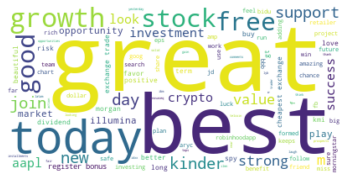

In [205]:
stopwords = set(STOPWORDS)
# add asset names and tickers to this list
stopwords.update(['https', 'http', 't', 's', 'll', 'mon'])

pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(samples['positive sample'])
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

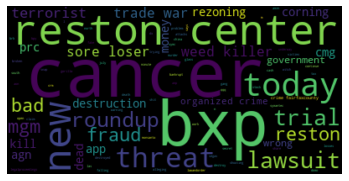

In [206]:
neg_wordcloud = WordCloud(stopwords=stopwords).generate(samples['negative sample'])
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [229]:
refined_tweet_df.hvplot.scatter(x='nltk_polarity', y='textblob_subjectivity')

:Scatter   [nltk_polarity]   (textblob_subjectivity)

In [210]:
refined_tweet_df[['nltk_polarity', 'textblob_subjectivity']].corr()

,nltk_polarity,textblob_subjectivity
nltk_polarity,1.000000,0.198259
textblob_subjectivity,0.198259,1.000000


In [214]:
vix_data_path = Path("vix_data.csv")
vix_data_df = pd.read_csv(vix_data_path)
vix_data_df.head()

,time,NEGATIVE,POSITIVE,pct,nltk_polarity
0,2022-04-04 02:00:00+00:00,70,47,0.401709,-0.004726
1,2022-04-04 03:00:00+00:00,47,50,0.515464,0.008890
2,2022-04-04 04:00:00+00:00,41,67,0.620370,0.119624
3,2022-04-04 05:00:00+00:00,27,44,0.619718,0.199152
4,2022-04-04 06:00:00+00:00,43,35,0.448718,0.087353


In [222]:
vix_path = Path("vix.csv")
vix_df = pd.read_csv(vix_path, skiprows=1)
vix_df.head()

,Date Time,Open,High,Low,Close,Change,Volume,Open Interest
0,4/04/2022 0:00,22.30,22.33,22.15,22.20,-0.10,87.0,NaN
1,4/04/2022 1:00,22.20,22.26,22.10,22.25,0.05,255.0,NaN
2,4/04/2022 2:00,22.20,22.57,22.15,22.45,0.20,537.0,NaN
3,4/04/2022 3:00,22.40,22.55,22.30,22.35,-0.10,403.0,NaN
4,4/04/2022 4:00,22.35,22.35,22.13,22.15,-0.20,378.0,NaN


In [223]:
vix_data = pd.concat([vix_data_df, vix_df['Change']], axis='columns', join='inner')
vix_data.head()

,time,NEGATIVE,POSITIVE,pct,nltk_polarity,Change
0,2022-04-04 02:00:00+00:00,70,47,0.401709,-0.004726,-0.10
1,2022-04-04 03:00:00+00:00,47,50,0.515464,0.008890,0.05
2,2022-04-04 04:00:00+00:00,41,67,0.620370,0.119624,0.20
3,2022-04-04 05:00:00+00:00,27,44,0.619718,0.199152,-0.10
4,2022-04-04 06:00:00+00:00,43,35,0.448718,0.087353,-0.20


In [225]:
vix_data.corr()

,NEGATIVE,POSITIVE,pct,nltk_polarity,Change
NEGATIVE,1.000000,0.585435,-0.452116,-0.297246,-0.091646
POSITIVE,0.585435,1.000000,0.425471,-0.209534,-0.026454
pct,-0.452116,0.425471,1.000000,0.143937,0.088663
nltk_polarity,-0.297246,-0.209534,0.143937,1.000000,-0.221765
Change,-0.091646,-0.026454,0.088663,-0.221765,1.000000


In [232]:
vix_data.hvplot.scatter(
    x='nltk_polarity',
    y='Change'
)

:Scatter   [nltk_polarity]   (Change)

In [258]:
def tweets(start_time, end_time, iterations, query):
    datelist = pd.date_range(start_time, end_time, periods=iterations).tolist()
    tweets=[]
    date=[]
    prob=[]
    sentim=[]
    a=0
    for time in datelist:
        if a>1:
            #Fetching Tweets
            response = client.search_recent_tweets(query, max_results=100, start_time=start, end_time=time, tweet_fields=["created_at"])
            response.data
            if type(response.data) != type(None):
                #Data Cleaning
                for i in response.data:
                    tw=i
                    tw=str(i)
                    tw=tw.lower()
                    tw=tw.split()
                    tw=' '.join(word for word in tw)
                    #Sentiment analysis
                    if len(tw) > 0:                        
                        tweets.append(tw)
                        date.append(i.created_at)                        
        start=time
        a=a+1
        
    tweet_df=pd.DataFrame({'time':date, 'tweet':tweets})
    tweet_df=tweet_df.sort_values(by='time', ascending=True).set_index('time')
    return tweet_df

In [259]:
btc_tweets = tweets('2022-04-05', '2022-04-11', 100, 'btc OR bitcoin OR crypto -is:retweet lang:en')

In [260]:
btc_tweets

,tweet
time,
2022-04-05 02:54:18+00:00,follow me!!! #bitcoin #btc #blockchain #bts #b...
2022-04-05 02:54:19+00:00,@dracoo_master i believe this is a faithful pr...
2022-04-05 02:54:19+00:00,"when $xrp moves, it turns the entire crypto sp..."
2022-04-05 02:54:19+00:00,"rt @mrbitcoinbaron: thank you for a 1,000 foll..."
2022-04-05 02:54:19+00:00,xrp is getting ready to fly to the moon! #xrp ...
...,...
2022-04-10 23:59:59+00:00,📈 ethusd buy signal now (severity: 3) #eth #cr...
2022-04-10 23:59:59+00:00,@crypto_whaler @drfamilyallergy @terareum @mil...
2022-04-10 23:59:59+00:00,rt @gemhostofficial: $2000 | 28 jy | honda cbr...


In [262]:
btc_data = build_sentiment_df(btc_tweets, 'tweet')

In [263]:
btc_data.head()

,tweets,cleaned_tweets,textblob_subjectivity,nltk_polarity
0,follow me!!! #bitcoin #btc #blockchain #bts #b...,follow bitcoin btc blockchain bts btsarmy btsx...,0.0000,0.0000
1,@dracoo_master i believe this is a faithful pr...,dracoo master believe faithful project project...,0.2125,0.9118
2,"when $xrp moves, it turns the entire crypto sp...",xrp moves turns entire crypto space dust xrp r...,0.6250,0.0000
3,"rt @mrbitcoinbaron: thank you for a 1,000 foll...",rt mrbitcoinbaron thank 1 000 followers love b...,0.6000,0.7717
4,xrp is getting ready to fly to the moon! #xrp ...,xrp getting ready fly moon xrp ripple bitcoin ...,0.7000,0.3612


In [265]:
btc_emoji = group_emojis(sorted(get_emoji_count(btc_data).items(), key=lambda x: x[1], reverse=True)) 

C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  import sys
C:\Users\gunin\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == '__main__':


In [266]:
btc_emoji

([('💎', 211), ('👉', 150), ('🔴', 136), ('🎁', 135), ('🏆', 113)],
 [('🔥', 1040), ('👇', 248), ('💥', 201), ('💰', 148), ('💸', 137)],
 [('💧', 74), ('📌', 55), ('🐑', 15), ('😭', 11), ('💀', 8)])

In [280]:
btc_ge1 = btc_emoji[0]
btc_ge2 = btc_emoji[1]
btc_ge3 = btc_emoji[2]

btc_pos_sample_df = pd.DataFrame(btc_ge1)
btc_neut_sample_df = pd.DataFrame(btc_ge2)
btc_neg_sample_df = pd.DataFrame(btc_ge3)

In [ ]:
btc_samples = get_samples(btc_data)
btc_samples['positive sample'] = " ".join(sample for sample in btc_samples['positive sample'])
btc_samples['negative sample'] = " ".join(sample for sample in btc_samples['negative sample'])
btc_samples

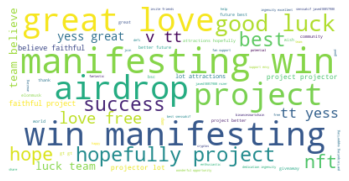

In [284]:
stopwords.update(['https', 'http', 't', 's', 'll', 'mon', 'bitcoin', 'btc', 'crypto', 'cryptocurrency', 'rt'])

btc_pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(btc_samples['positive sample'])
plt.imshow(btc_pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

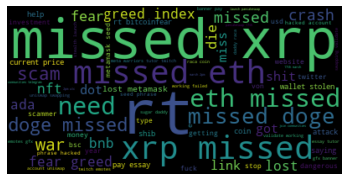

In [283]:
btc_neg_wordcloud = WordCloud(stopwords=stopwords).generate(btc_samples['negative sample'])
plt.imshow(btc_neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
eth_tweets = tweets('2022-04-05', '2022-04-11', 100, 'btc OR bitcoin OR crypto -is:retweet lang:en')